###### Reading in dependencies

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split, KFold, GridSearchCV,\
cross_val_score, RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE, RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.metrics import f1_score, confusion_matrix, recall_score, precision_score, accuracy_score
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, f1_score, recall_score, confusion_matrix, classification_report, make_scorer
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn import tree 
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE

sns.set_style('whitegrid')

# Modeling the NBA Leap

This project applies machine learning classification to predict whether NBA players will make 'All NBA' teams in seasons 4 - 6, based upon thier first 3 season statistics. The structure of our model will be based upon inference, as the goal is to educate front offices on what player statistics correlate the most with future NBA stars. The model will focus on the 'precision' metric as we are aiming to minimize our false positives (predicting an NBA star when the player is not.)

## Defining 'The Leap'

“A player’s identity typically begins to crystallize in his third or fourth NBA season. Young players have learned the ropes, and veterans have departed or aged, vacating heavy-duty roles that need filling. Everyone involved — players, agents, executives — looks to see what emerges as a player nears the expiration of his rookie contract.” - Zach Lowe, NBA Analyst for ESPN/Grantland


## Business Problem

Each year 60 NBA players are drafted into the league and many others are signed as non-drafted free agents. Dependent on what round players are drafted in, rookie contracts can stretch from 2 to 4 years, with team options in the 3rd and 4th year. Its imperative for NBA front offices to be able identify if their recently drafted players will make the leap from productive NBA player to All NBA star.

Why is this important? Salary cap for the NBA in 2020-21 season is at $109M and first round draft picks who sign a 'max rookie scale extension' at the end of thier rookie deal can demand contracts up to 25% of the salary cap. Meaning its so important to correctly identify these players, as you don't want such a large percentage of your team's salary cap tied to a player who is not living up to expectations.

## Data

Data acquisition and compiling can be found in seperate notebooks saved [here.](https://github.com/rylewww/Modeling-The-NBA-Leap/tree/main/Notebooks)

I used Selenium webdriver to scrape both 'standard' and 'advanced' seasonal statistics of all NBA players dating back to 1947 from stathead.com. I then merged datasets containing NBA draft history, All NBA selections, All Rookie teams and All Defensive teams and began to aggregate all data down to one row representing the first 3 years of a players career. Our target is binary, '1' representing a player who was selected to an All NBA team in years 4-6, and '0' for those who were not.


In [58]:
#Reading in full non-aggregated data set for EDA
full_df = pd.read_csv('Data/Final_NBA_PLayers_updated.csv', index_col = 0)
#Reading in compiled 1-3 season data set
df_final = pd.read_csv('Data/Final_NBA_Seasons1-3_1977_final.csv', index_col = 0)
df_final.set_index('Player', inplace = True)
df_final.head()

,G,GS,MP,FG,FGA,2P,2PA,3P,3PA,FT,...,DWS_1-2,DWS_2-3,PER_1-2,PER_2-3,USG_1-2,USG_2-3,VORP_1-2,VORP_2-3,target,Qualified
Player,,,,,,,,,,,,,,,,,,,,,
A.C. Green\greenac01,243,137.0,6418.0,847,1615,846,1602,1.0,13.0,615,...,1.3,0.1,3.9,-1.2,0.0,0.0,1.5,-0.2,0,1.0
A.J. Price\priceaj01,150,3.0,2228.0,318,848,191,437,127.0,411.0,142,...,-0.1,-0.2,-3.3,0.8,0.0,-5.0,-0.5,0.3,0,1.0
Aaron Brooks\brookaa01,213,117.0,5525.0,984,2339,626,1396,358.0,943.0,436,...,1.4,-0.6,-0.2,3.1,1.1,2.8,0.3,1.3,0,1.0
Aaron Gordon\gordoaa01,205,117.0,4958.0,760,1652,628,1195,132.0,457.0,329,...,1.5,-0.5,5.6,-2.5,1.8,2.8,1.6,-0.8,0,1.0
Aaron Gray\grayaa01,149,19.0,1639.0,226,453,226,451,0.0,2.0,110,...,0.0,-0.4,-2.4,5.1,-7.5,1.9,0.0,0.3,0,1.0


Final Data Set was subset to players who's rookie year was 1977 and later, advanced statistics such as Win-Share and VORP were not tracked prior to 1977. Furthermore, qualified players need to play a minumum of six years in the league as our target variable is All NBA selections in seasons 4 through 6. This left us with the following population breakdown:

([<matplotlib.axis.XTick at 0x7fab694c29d0>,
 [Text(0, 0, 'Not All NBA'), Text(1, 0, 'All NBA')])

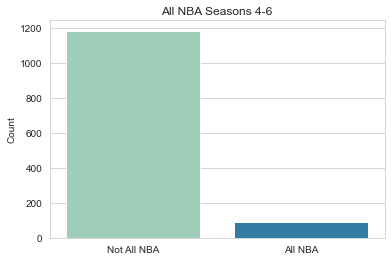

In [59]:
#barplot showing target class imbalance
sns.barplot(x = df_final['target'].value_counts().index, y = df_final['target'].value_counts(), palette = 'YlGnBu')
plt.title('All NBA Seasons 4-6')
plt.ylabel('Count')
plt.xticks([0,1],['Not All NBA', 'All NBA'])

## Exploratory Data Analysis

Once the data was properly formatted and cleaned, I began to explore and investigate which features correlated the most with our 'All NBA 4-6' target variable. It became clear that future All NBA players differentiate themselves from the rest of the league with statistic totals in the first three years.

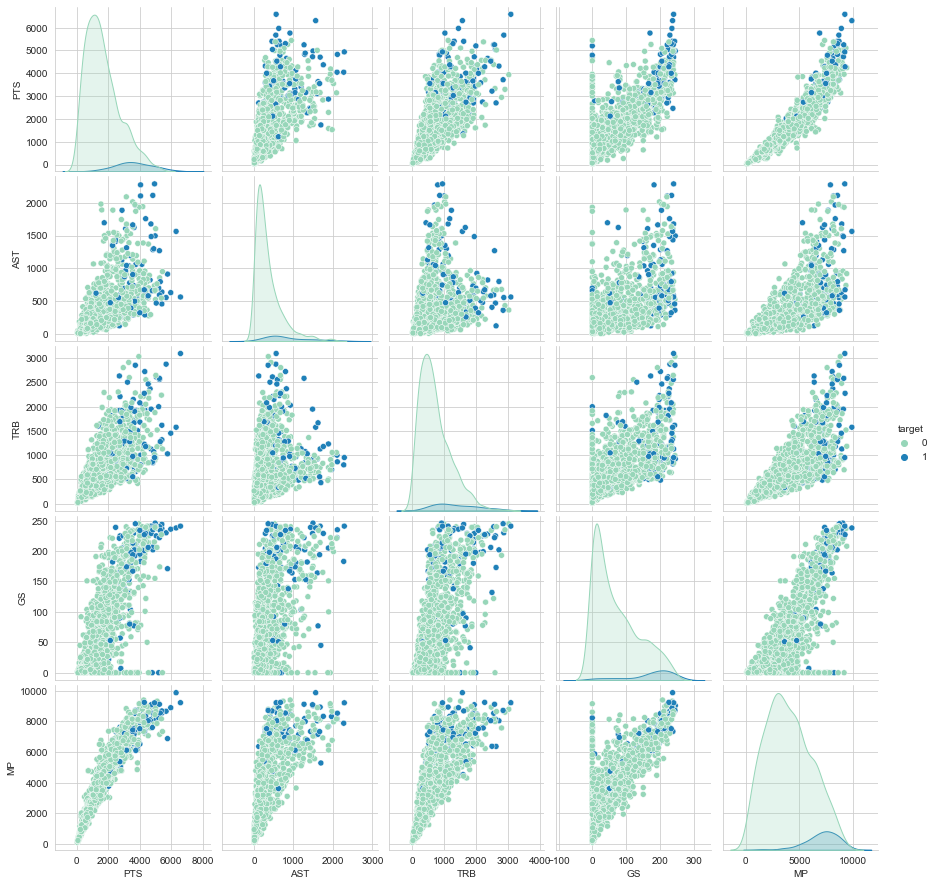

In [60]:
#basic pairplot showing how season 1-3 stat totals can help identify future All-NBA players
pair_plt_stats = df_final[['PTS','AST','TRB','GS', 'MP','target']]

sns.pairplot(pair_plt_stats, hue = 'target', palette = 'YlGnBu')

# plt.savefig('nba_pair_plt_basic.png')
plt.show();

The following pairplots show the relationship between advanced statistics and thier relationship with our target variable over the first 3 seasons of an NBA players career. All NBA players visually begin to differntiate themselves from the rest of the league in seasons 2 and 3.

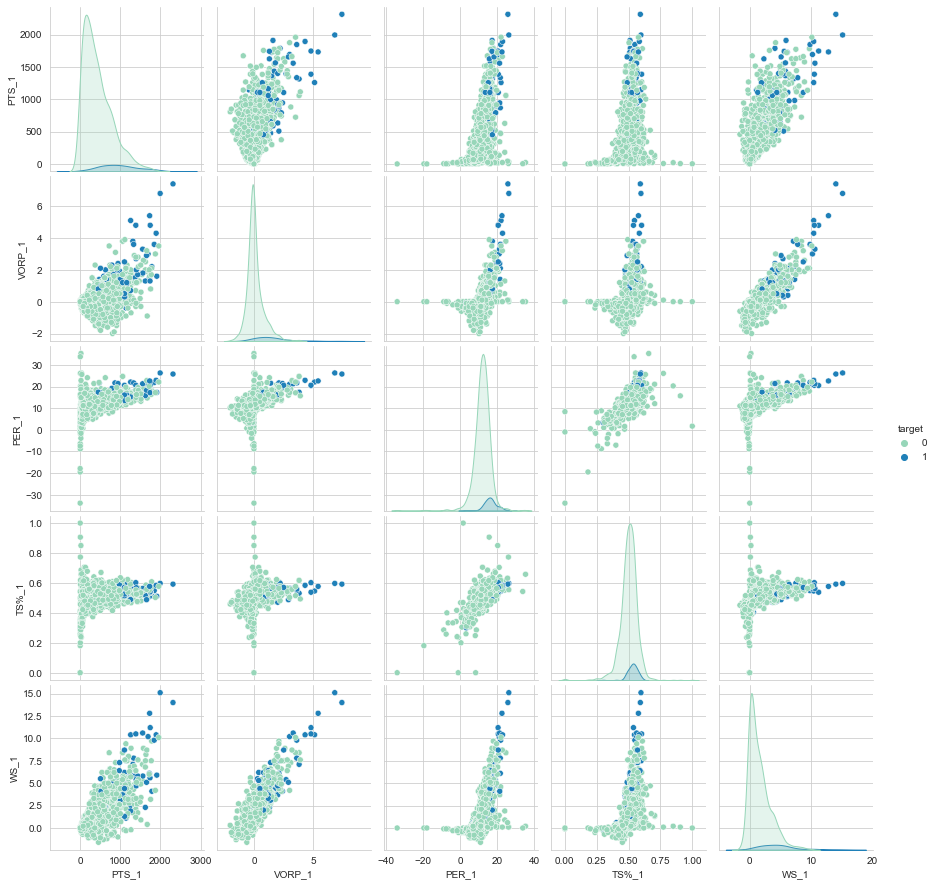

In [61]:
#season one advanced stats
pair_plt_stats = df_final[['PTS_1','VORP_1','PER_1','TS%_1','WS_1','target']]

sns.pairplot(pair_plt_stats, hue = 'target', palette = 'YlGnBu')

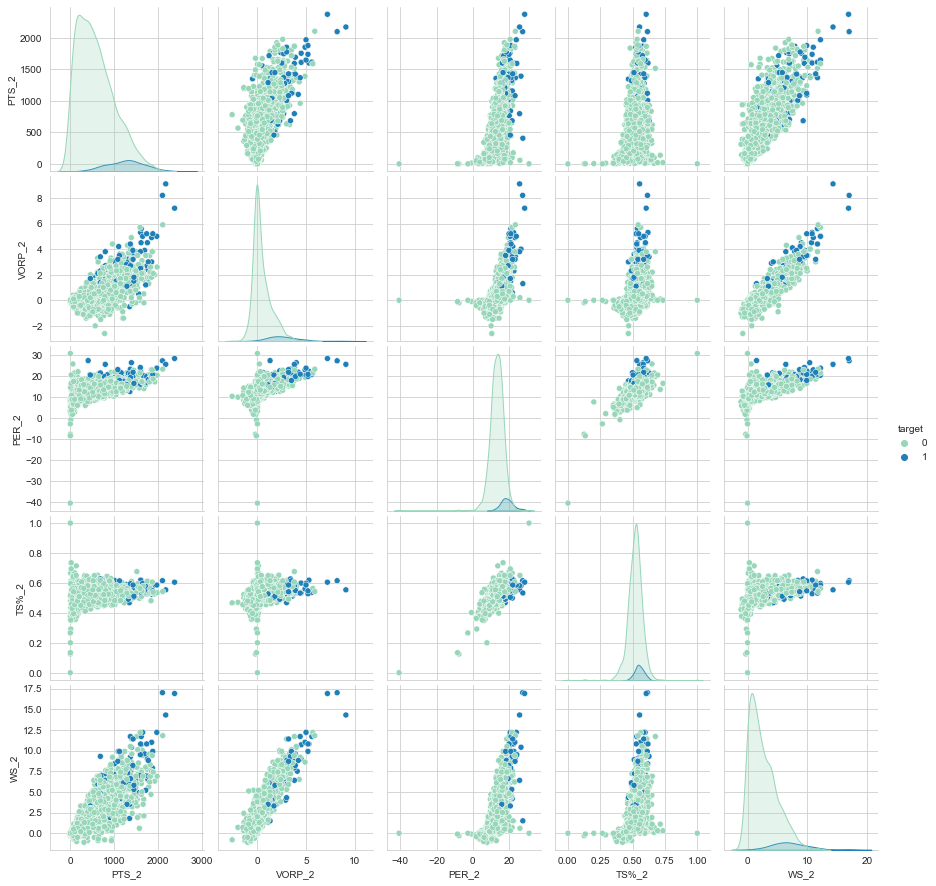

In [62]:
#season 2 advanced stats
pair_plt_stats = df_final[['PTS_2','VORP_2','PER_2','TS%_2','WS_2','target']]

sns.pairplot(pair_plt_stats, hue = 'target', palette = 'YlGnBu')

In [63]:
# removing 3rd season PER outliers
df_final['PER_3'] = np.where(df_final.PER_3 > 34, 0, df_final.PER_3)

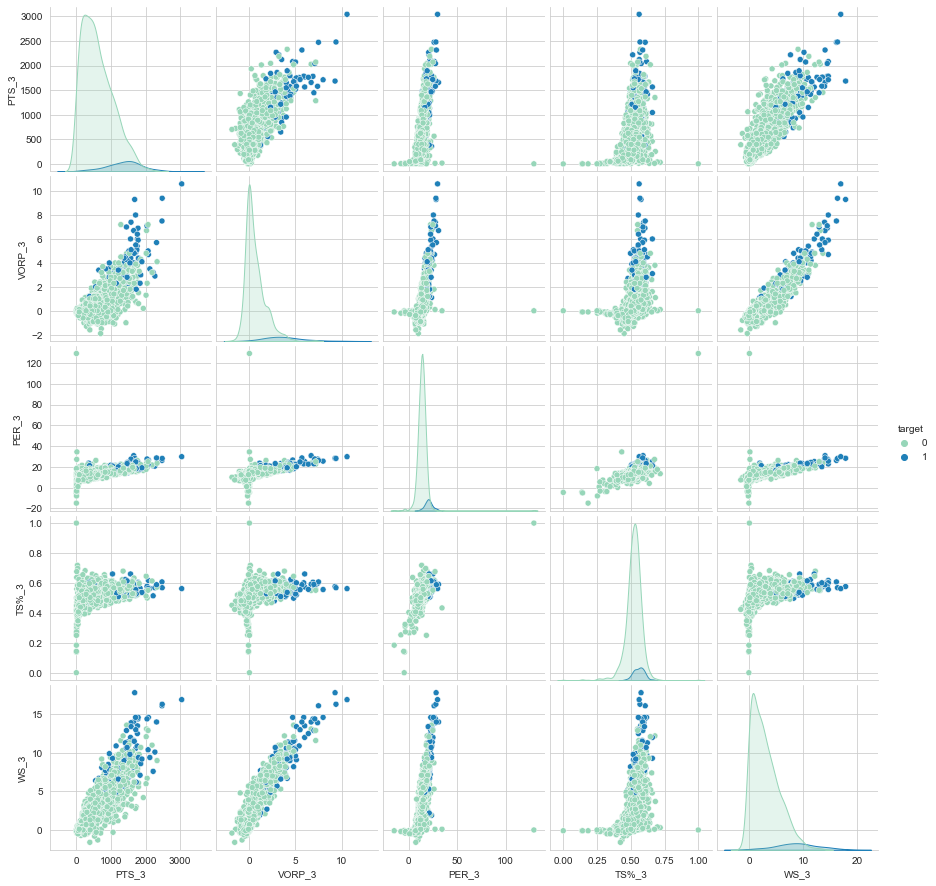

In [64]:
#season three advanced stats
pair_plt_stats = df_final[['PTS_3','VORP_3','PER_3','TS%_3','WS_3','target']]

sns.pairplot(pair_plt_stats, hue = 'target', palette = 'YlGnBu')

The 3D plot below allows you to see how strongly season three advanced statistics are able to help identify future All-NBA plauers in seasons four through six.

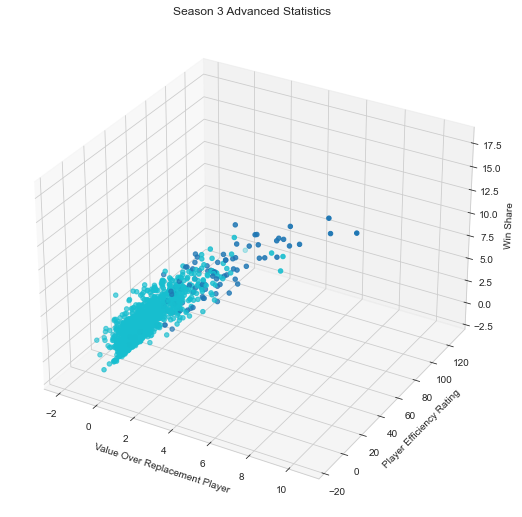

In [100]:
fig = plt.figure(figsize = (16, 9))
ax = plt.axes(projection ="3d")

ax.scatter3D(xs = df_final.VORP_3, ys = df_final.PER_3, zs = df_final.WS_3, c= df_final.target, cmap = 'tab10_r')
plt.title('Season 3 Advanced Statistics')
plt.xlabel('Value Over Replacement Player')
plt.ylabel('Player Efficiency Rating')
ax.set_zlabel('Win Share')
# ax.legend(labels = df_final.target)
# plt.savefig('Season 3 Scatter',
#            transparent = True)
plt.show()

## Feature Engineering

The majority of my feature engineering was done during my dataset compiling. 

Continuous features include:
* Per game statistics
* Year 2 v Year 1 increase/decrease
* Year 3 v Year 2 increase/decrease

Categorical features include:
* Rookie of the Year awards
* All Defensive Selections
* Categorical statistic improvements over each season


In [66]:
#YoY categorial variable increases
df_final['VORP_Incr'] = np.where((df_final['VORP_1-2'] > 0) & (df_final['VORP_2-3'] > 0),1,0) 
df_final['PER_Incr'] = np.where((df_final['PER_1-2'] > 0) & (df_final['PER_2-3'] > 0),1,0) 
df_final['USG_Incr'] = np.where((df_final['USG_1-2'] > 0) & (df_final['USG_2-3'] > 0),1,0)
df_final['WS_Incr'] = np.where((df_final['WS_1-2'] > 0) & (df_final['WS_2-3'] > 0),1,0)
df_final['PPG_Incr'] = np.where((df_final['PPG_1-2'] > 0) & (df_final['PPG_2-3'] > 0),1,0)

Unfortunately, none of the year over year features I enginered made it into our final modeling process. This could potentially indicate that future All-NBA players come into the NBA playing at a high level and do not need to display massive growth over the first three years of thier careers.

In [67]:
#adding in rookie season
rookie_df = full_df[full_df['season_count'] == 1]
rookie_df = rookie_df[['Player','Season']]
df_final = df_final.merge(rookie_df, how = 'left', on = 'Player')

df_final['year_split'] = df_final['Season'].str.split('-')
df_final['award_year'] = [x[1] for x in df_final['year_split']]
df_final['season_year'] = [x[0] for x in df_final['year_split']]
df_final['season_year'] = df_final['season_year'].astype(int)
df_final.head()

,Player,G,GS,MP,FG,FGA,2P,2PA,3P,3PA,...,Qualified,VORP_Incr,PER_Incr,USG_Incr,WS_Incr,PPG_Incr,Season,year_split,award_year,season_year
0,A.C. Green\greenac01,243,137.0,6418.0,847,1615,846,1602,1.0,13.0,...,1.0,0,0,0,1,1,1985-86,"[1985, 86]",86,1985
1,A.J. Price\priceaj01,150,3.0,2228.0,318,848,191,437,127.0,411.0,...,1.0,0,0,0,0,0,2009-10,"[2009, 10]",10,2009
2,Aaron Brooks\brookaa01,213,117.0,5525.0,984,2339,626,1396,358.0,943.0,...,1.0,1,0,1,1,1,2007-08,"[2007, 08]",08,2007
3,Aaron Gordon\gordoaa01,205,117.0,4958.0,760,1652,628,1195,132.0,457.0,...,1.0,0,0,1,0,1,2014-15,"[2014, 15]",15,2014
4,Aaron Gray\grayaa01,149,19.0,1639.0,226,453,226,451,0.0,2.0,...,1.0,0,0,0,0,0,2007-08,"[2007, 08]",08,2007


In [68]:
df_final.set_index('Player', inplace = True)
df_final.head()

,G,GS,MP,FG,FGA,2P,2PA,3P,3PA,FT,...,Qualified,VORP_Incr,PER_Incr,USG_Incr,WS_Incr,PPG_Incr,Season,year_split,award_year,season_year
Player,,,,,,,,,,,,,,,,,,,,,
A.C. Green\greenac01,243,137.0,6418.0,847,1615,846,1602,1.0,13.0,615,...,1.0,0,0,0,1,1,1985-86,"[1985, 86]",86,1985
A.J. Price\priceaj01,150,3.0,2228.0,318,848,191,437,127.0,411.0,142,...,1.0,0,0,0,0,0,2009-10,"[2009, 10]",10,2009
Aaron Brooks\brookaa01,213,117.0,5525.0,984,2339,626,1396,358.0,943.0,436,...,1.0,1,0,1,1,1,2007-08,"[2007, 08]",08,2007
Aaron Gordon\gordoaa01,205,117.0,4958.0,760,1652,628,1195,132.0,457.0,329,...,1.0,0,0,1,0,1,2014-15,"[2014, 15]",15,2014
Aaron Gray\grayaa01,149,19.0,1639.0,226,453,226,451,0.0,2.0,110,...,1.0,0,0,0,0,0,2007-08,"[2007, 08]",08,2007


### Correlation Plot

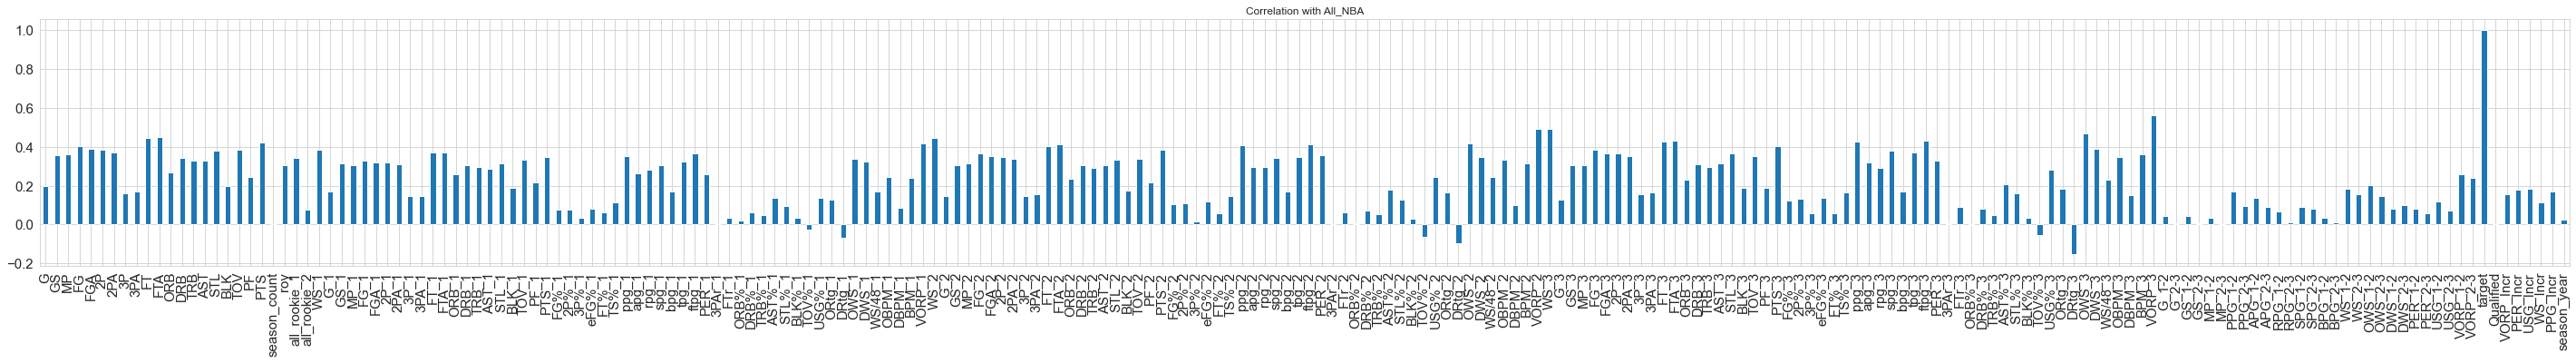

In [69]:
df_final.corrwith(df_final.target).plot.bar(figsize = (50, 5), title = "Correlation with All_NBA", 
                                        fontsize = 15,rot = 90, grid = True);

After cleaning our dataset and adding our newly created feature engineering - we were left with over 200 features to work with. This many features can lead to overfitting models on the training data set, so we will need to reduce our dimensionality using recursive feature elimination.

## Recursive Feature Elimination

After reducing the number of features down with correlation analysis, I was left with the following columns:

In [70]:
cols = ['MP','FG','2P','FT','TRB','AST','STL','TOV','PTS','roy','all_rookie_1','all_rookie_2','WS_1','GS_1','MP_1','PTS_1','ppg_1','apg_1','rpg_1','spg_1','bpg_1',
        'tpg_1','ftpg_1','PER_1','WS/48_1','VORP_1','WS_2','GS_2','MP_2','ppg_2','apg_2','rpg_2','spg_2','bpg_2','tpg_2','ftpg_2','PER_2','USG%_2',
        'ORtg_2','DRtg_2','OWS_2','DWS_2','WS/48_2','VORP_2','WS_3','GS_3','MP_3','PTS_3','TS%_3','ppg_3','apg_3','rpg_3','spg_3','bpg_3','tpg_3','ftpg_3','PER_3','USG%_3',
        'ORtg_3','DRtg_3','OWS_3','DWS_3','WS/48_3','VORP_3','VORP_1-2','VORP_2-3','season_year','target',]

df = df_final[cols]
df = df.fillna(0)
df.head()

,MP,FG,2P,FT,TRB,AST,STL,TOV,PTS,roy,...,ORtg_3,DRtg_3,OWS_3,DWS_3,WS/48_3,VORP_3,VORP_1-2,VORP_2-3,season_year,target
Player,,,,,,,,,,,,,,,,,,,,,
A.C. Green\greenac01,6418.0,847,846,615,1706.0,231,206.0,321.0,2310,0.0,...,119.0,106.0,4.5,3.4,0.144,1.5,1.5,-0.2,1985,0
A.J. Price\priceaj01,2228.0,318,191,142,221.0,303,84.0,144.0,905,0.0,...,100.0,106.0,0.2,0.5,0.063,0.1,-0.5,0.3,2009,0
Aaron Brooks\brookaa01,5525.0,984,626,436,428.0,759,128.0,401.0,2762,0.0,...,108.0,112.0,3.9,1.6,0.091,1.9,0.3,1.3,2007,0
Aaron Gordon\gordoaa01,4958.0,760,628,329,1081.0,311,145.0,193.0,1981,0.0,...,107.0,111.0,2.0,1.7,0.077,0.6,1.6,-0.8,2014,0
Aaron Gray\grayaa01,1639.0,226,226,110,494.0,109,44.0,115.0,562,0.0,...,115.0,106.0,0.5,0.4,0.142,0.1,0.0,0.3,2007,0


I then applied recursive feature elimination to further reduce the dimensionality of our data set

In [71]:
#Train-test-split
X = df.drop(columns = 'target')
y = df['target']

X_train, X_test, y_train, y_test =  train_test_split(X, y, train_size= .8, random_state= 42)

In [72]:
nba_scaled = StandardScaler()

nba_scaled.fit(X_train)
X_train_sc = pd.DataFrame(nba_scaled.transform(X_train), index = X_train.index, columns = X_train.columns)
X_test_sc = pd.DataFrame(nba_scaled.transform(X_test), index = X_test.index, columns = X_test.columns)

After splitting our data into training and testing sets, I pulled in our features that were selected through my recursive feature analysis detailed in my modeling notebook.

#### Logistic Regression RFE

In [79]:
lr_cols = ['TRB', 'PTS', 'spg_1', 'tpg_1', 'MP_2', 'bpg_2', 'PER_2', 'MP_3',
       'TS%_3', 'spg_3', 'PER_3', 'VORP_3', 'season_year']

For Logistic Regression Models - we need to make sure our features are not overly correlated with one and another.

#### Random Forest RFE

In [77]:
rf_cols =['PTS', 'WS_2', 'PER_2', 'VORP_2', 'PER_3', 'VORP_3', 'season_year']

For Random Forest it does not matter if our features are correlated with one and another.

#### Decision Tree RFE

In [80]:
dt_cols = ['FT', 'PER_1', 'WS_2', 'GS_2', 'VORP_2', 'rpg_3', 'spg_3', 'PER_3', 'season_year']

## Modeling

In efforts to best understand what statistics highlight young NBA players potential growth to All NBA stars, the models I focused on were all interpretable. Additionally, they were all grid-searched to best tune our hyperparameters and scored based on the 'precision' metric to reduce our false positives.

In [82]:
# create function to call for evaluation of each model
def metrics_score(train_preds, y_train, test_preds, y_test):
    print(f"Training Accuracy:\t{accuracy_score(y_train, train_preds):.4}",
          f"\tTesting Accuracy:\t{accuracy_score(y_test, test_preds):.4}")
    print(f"Training Precision:\t{precision_score(y_train, train_preds):.4}",
          f"\tTesting Precision:\t{precision_score(y_test, test_preds):.4}")
    print(f"Training Recall:\t{recall_score(y_train, train_preds):.4}",
          f"\tTesting Recall:\t\t{recall_score(y_test, test_preds):.4}")
    print(f"Training F1:\t\t{f1_score(y_train, train_preds):.4}",
          f"\tTesting F1:\t\t{f1_score(y_test, test_preds):.4}")
#defining which metric our models will focus on
scorer = make_scorer(recall_score, average='weighted')

### Logistic Regression 

First up is the Logistic Regression model. After Grid-searching, I used models trained as is and models trained with SMOTE resampling. Surprisingly, the non-resampled model performed better, but even with the scorer set to 'Precision' it only scored a 0.625 for precision. It's recall metric was not much better at 0.556.

In [85]:
C = np.logspace(0, 1, 10)

params = dict(C=C, max_iter=[50, 100], class_weight = ['balanced', None])

logistic = LogisticRegression(penalty='l2', random_state=42)

grid_search_LR = GridSearchCV(estimator = logistic,scoring=scorer, param_grid = params, 
                              cv = 3, n_jobs = -1, verbose = 2)

grid_search_LR.fit(X_train_sc[lr_cols], y_train)

lrgsrfe_train_preds = grid_search_LR.best_estimator_.predict(X_train_sc[lr_cols])
lrgsrfe_test_preds = grid_search_LR.best_estimator_.predict(X_test_sc[lr_cols])
metrics_score(lrgsrfe_train_preds, y_train, lrgsrfe_test_preds, y_test)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:    0.9s


Training Accuracy:	0.9528 	Testing Accuracy:	0.9451
Training Precision:	0.7609 	Testing Precision:	0.625
Training Recall:	0.4861 	Testing Recall:		0.5556
Training F1:		0.5932 	Testing F1:		0.5882


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    1.6s finished


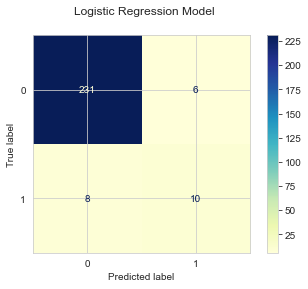

In [86]:
fig, ax = plt.subplots()

fig.suptitle("Logistic Regression Model")

plot_confusion_matrix(grid_search_LR, X_test_sc[lr_cols], y_test, ax=ax, cmap="YlGnBu");

### Logistic Regression w/ SMOTE Resampling

In [87]:
sm = SMOTE(random_state = 42)
X_train_res, y_train_res = sm.fit_sample(X_train_sc[lr_cols], y_train.ravel())

C = np.logspace(0, 1, 10)

params = dict(C=C, max_iter=[50, 100], class_weight = ['balanced', None])

logistic = LogisticRegression(penalty='l2', random_state=42)

grid_search_LR_sm = GridSearchCV(estimator = logistic,scoring=scorer, param_grid = params, 
                              cv = 3, n_jobs = -1, verbose = 2)
grid_search_LR_sm.fit(X_train_res, y_train_res)

lr_train_preds_sm = grid_search_LR_sm.best_estimator_.predict(X_train_res)
lr_test_preds_sm = grid_search_LR_sm.best_estimator_.predict(X_test_sc[lr_cols])
metrics_score(lr_train_preds_sm, y_train_res, lr_test_preds_sm, y_test)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.5s


Training Accuracy:	0.9419 	Testing Accuracy:	0.8941
Training Precision:	0.9197 	Testing Precision:	0.3784
Training Recall:	0.9683 	Testing Recall:		0.7778
Training F1:		0.9434 	Testing F1:		0.5091


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    5.3s finished


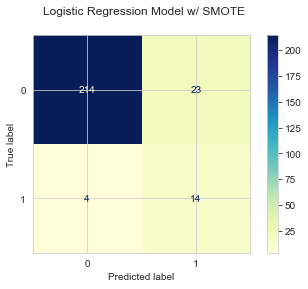

In [88]:
fig, ax = plt.subplots()

fig.suptitle("Logistic Regression Model w/ SMOTE")

plot_confusion_matrix(grid_search_LR_sm, X_test_sc[lr_cols], y_test, ax=ax, cmap="YlGnBu");

### Random Forest Model

Similar to our Logisitic Regression models, we ran both 'as is' and resampled models. While again, our resampled model did not produce great results, our regular Random Forest model came back with a test precision score of 0.75! This shows that it does a strong job reducing its false positive predictions - which is what our business querstion is focusing on. Overall it does a decent job with an F1 score of 60%.

In [89]:
params = { 
    'n_estimators': [10, 25, 50, 100, 200, 500],
    'max_features': ['sqrt', 'auto', 'log2'],
    'max_depth' : [2,4,6,8,10,12,15,20],
    'criterion' :['gini', 'entropy']
}

rf = RandomForestClassifier(random_state = 42)

grid_search_RF = GridSearchCV(estimator=rf, param_grid=params, scoring=scorer, 
                              cv = 5, n_jobs = -1, verbose = 2)

grid_search_RF.fit(X_train_sc[rf_cols], y_train)

rf_train_preds = grid_search_RF.best_estimator_.predict(X_train_sc[rf_cols])
rf_test_preds = grid_search_RF.best_estimator_.predict(X_test_sc[rf_cols])
metrics_score(rf_train_preds, y_train, rf_test_preds, y_test)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   35.3s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:  8.0min finished


Training Accuracy:	0.9833 	Testing Accuracy:	0.9529
Training Precision:	1.0 	Testing Precision:	0.75
Training Recall:	0.7639 	Testing Recall:		0.5
Training F1:		0.8661 	Testing F1:		0.6


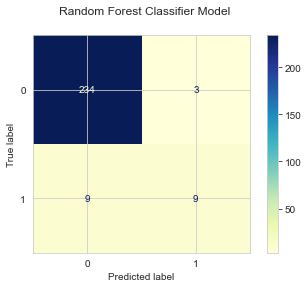

In [90]:
fig, ax = plt.subplots()

fig.suptitle("Random Forest Classifier Model")

plot_confusion_matrix(grid_search_RF, X_test_sc[rf_cols], y_test, ax=ax, cmap="YlGnBu");



### Random Forest w/ SMOTE Resampling

In [91]:
sm = SMOTE(random_state = 42)
X_train_res, y_train_res = sm.fit_sample(X_train_sc[rf_cols], y_train.ravel())

params = { 
    'n_estimators': [10, 25, 50, 100, 200, 500],
    'max_features': ['sqrt', 'auto', 'log2'],
    'max_depth' : [2,4,6,8,10,12,15,20],
    'criterion' :['gini', 'entropy']
}

rf = RandomForestClassifier(random_state = 42)

grid_search_RF_sm = GridSearchCV(estimator=rf, param_grid=params, scoring=scorer, 
                              cv = 5, n_jobs = -1, verbose = 2)

grid_search_RF_sm.fit(X_train_res, y_train_res)

rf_train_preds_sm = grid_search_RF_sm.best_estimator_.predict(X_train_res)
rf_test_preds_sm = grid_search_RF_sm.best_estimator_.predict(X_test_sc[rf_cols])
metrics_score(rf_train_preds_sm, y_train_res, rf_test_preds_sm, y_test)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   35.4s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:  8.0min finished


Training Accuracy:	1.0 	Testing Accuracy:	0.9216
Training Precision:	1.0 	Testing Precision:	0.4643
Training Recall:	1.0 	Testing Recall:		0.7222
Training F1:		1.0 	Testing F1:		0.5652


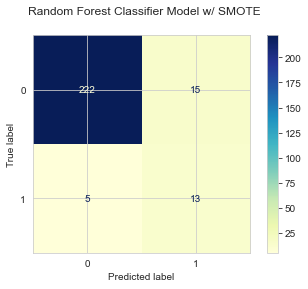

In [92]:
fig, ax = plt.subplots()

fig.suptitle("Random Forest Classifier Model w/ SMOTE")

plot_confusion_matrix(grid_search_RF_sm, X_test_sc[rf_cols], y_test, ax=ax, cmap="YlGnBu");

### Decision Tree Model

Lastly, for our interpretable models, we ran two kinds of Decision Tree models. Both were grid-searched and unlike the other two models, our Decision Tree model improved with SMOTER resampling. Though, with a Precision score of .42 - it was not considered for further consideration. This makes sense, as Random Forest is a more advanced version of a Decision Tree model

In [93]:
criterion = ['gini', 'entropy']
max_depth = [2,4,6,8,10,12]

params = dict(criterion=['gini', 'entropy'],
                max_depth=[2,4,6,8,10,12,15,20,25],
                 splitter = ['best', 'random'],
             )

DT = tree.DecisionTreeClassifier(random_state = 42, class_weight = 'balanced')

grid_search_DT = GridSearchCV(estimator=DT, param_grid=params, scoring=scorer, 
                              cv = 5, n_jobs = -1, verbose = 2)

grid_search_DT.fit(X_train_sc[dt_cols], y_train)

dtrfegs_train_preds = grid_search_DT.best_estimator_.predict(X_train_sc[dt_cols])
dtrfegs_test_preds = grid_search_DT.best_estimator_.predict(X_test_sc[dt_cols])
metrics_score(dtrfegs_train_preds, y_train, dtrfegs_test_preds, y_test)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:    1.3s


Training Accuracy:	1.0 	Testing Accuracy:	0.898
Training Precision:	1.0 	Testing Precision:	0.3182
Training Recall:	1.0 	Testing Recall:		0.3889
Training F1:		1.0 	Testing F1:		0.35


[Parallel(n_jobs=-1)]: Done 173 out of 180 | elapsed:    2.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:    2.3s finished


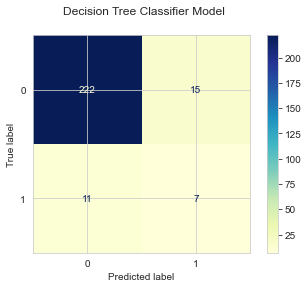

In [94]:
fig, ax = plt.subplots()

fig.suptitle("Decision Tree Classifier Model")

plot_confusion_matrix(grid_search_DT, X_test_sc[dt_cols], y_test, ax=ax, cmap="YlGnBu");

### Decision Tree w/ SMOTE Resampling

In [95]:
sm = SMOTE(random_state = 42)
X_train_res, y_train_res = sm.fit_sample(X_train_sc[dt_cols], y_train.ravel())

criterion = ['gini', 'entropy']
max_depth = [2,4,6,8,10,12]

params = dict(criterion=['gini', 'entropy'],
                max_depth=[2,4,6,8,10,12,15,20,25],
                 splitter = ['best', 'random'],
             )

DT = tree.DecisionTreeClassifier(random_state = 42, class_weight = 'balanced')

grid_search_DT_sm = GridSearchCV(estimator=DT, param_grid=params, scoring=scorer, 
                              cv = 5, n_jobs = -1, verbose = 2)

grid_search_DT_sm.fit(X_train_res, y_train_res)

dtrfegssm_train_preds = grid_search_DT_sm.best_estimator_.predict(X_train_res)
dtrfegssm_test_preds = grid_search_DT_sm.best_estimator_.predict(X_test_sc[dt_cols])
metrics_score(dtrfegssm_train_preds, y_train_res, dtrfegssm_test_preds, y_test)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    1.5s


Training Accuracy:	0.9921 	Testing Accuracy:	0.9137
Training Precision:	0.9854 	Testing Precision:	0.4231
Training Recall:	0.9989 	Testing Recall:		0.6111
Training F1:		0.9921 	Testing F1:		0.5


[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:    1.9s finished


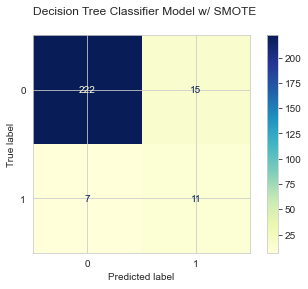

In [96]:
fig, ax = plt.subplots()

fig.suptitle("Decision Tree Classifier Model w/ SMOTE")

plot_confusion_matrix(grid_search_DT_sm, X_test_sc[dt_cols], y_test, ax=ax, cmap="YlGnBu");

## Results

A break down of the modeling results is below. Our two best models were Random Forest and 

In [99]:
model_candidates = [
    
    {'name':'Logistic Regression',
     'accuracy score':accuracy_score(y_test, lrgsrfe_test_preds),
     'recall score' : recall_score(y_test, lrgsrfe_test_preds),
     'precision score' : precision_score(y_test,lrgsrfe_test_preds),
         'f1 score':metrics.f1_score(y_test, lrgsrfe_test_preds)},
    
    {'name':'Logistic Regression w/ Resampling',
     'accuracy score':accuracy_score(y_test, lr_test_preds_sm),
     'recall score' : recall_score(y_test, lr_test_preds_sm),
     'precision score' : precision_score(y_test,lr_test_preds_sm),
     'f1 score':metrics.f1_score(y_test, lr_test_preds_sm)},
    
    {'name':'Random Forest',
     'accuracy score':accuracy_score(y_test, rf_test_preds),
     'recall score' : recall_score(y_test, rf_test_preds,),
     'precision score' : precision_score(y_test,rf_test_preds),
    'f1 score':metrics.f1_score(y_test, rf_test_preds)},
    
    {'name':'Random Forest w/ Resampling',
     'accuracy score':accuracy_score(y_test, rf_test_preds_sm),
     'recall score' : recall_score(y_test, rf_test_preds_sm),
     'precision score' : precision_score(y_test,rf_test_preds_sm),
     'f1 score':metrics.f1_score(y_test, rf_test_preds_sm)},
    
    {'name':'Decision Tree',
     'accuracy score':accuracy_score(y_test, dtrfegs_test_preds),
     'recall score' : recall_score(y_test, dtrfegs_test_preds),
     'precision score' : precision_score(y_test,dtrfegs_test_preds),
     'f1 score':metrics.f1_score(y_test, dtrfegs_test_preds)},
    
    {'name':'Decision Tree w/ Resampling',
     'accuracy score':accuracy_score(y_test, dtrfegssm_test_preds),
     'recall score' : recall_score(y_test, dtrfegssm_test_preds),
     'precision score' : precision_score(y_test,dtrfegssm_test_preds),
     'f1 score':metrics.f1_score(y_test, dtrfegssm_test_preds)},
    
]
final_scores_df = pd.DataFrame(model_candidates).set_index('name')
final_scores_df

,accuracy score,recall score,precision score,f1 score
name,,,,
Logistic Regression,0.945098,0.555556,0.625000,0.588235
Logistic Regression w/ Resampling,0.894118,0.777778,0.378378,0.509091
Random Forest,0.952941,0.500000,0.750000,0.600000
Random Forest w/ Resampling,0.921569,0.722222,0.464286,0.565217
Decision Tree,0.898039,0.388889,0.318182,0.350000
Decision Tree w/ Resampling,0.913725,0.611111,0.423077,0.500000


The Random Forest model produced the best results with an Accuracy score of 95.2%, a Precision score of 75% and an overall F1 Score of 60% showing the model is functioning decently across the board. Below shows  which features the model found most important when identifying future All NBA players. As identified during our EDA process, season three advanced statistics PER & VORP lead the charge in terms of significance in our model, followed by total points over a players first three seasons.

Feature: 0, Score: 0.13861
Feature: 1, Score: 0.10233
Feature: 2, Score: 0.10827
Feature: 3, Score: 0.12096
Feature: 4, Score: 0.21247
Feature: 5, Score: 0.24169
Feature: 6, Score: 0.07567


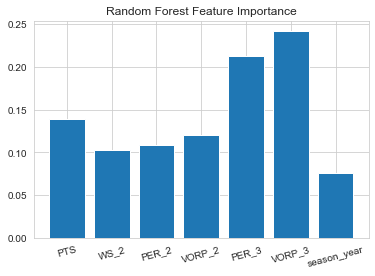

In [101]:
importance = grid_search_RF.best_estimator_.feature_importances_

for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.xticks([0,1,2,3,4,5,6],['PTS', 'WS_2', 'PER_2', 'VORP_2', 'PER_3', 'VORP_3', 'season_year'], rotation = 15)
plt.title('Random Forest Feature Importance')
# plt.savefig('Feature_Importance_transparent',
#            transparent = True)
plt.show()

# Conclusion

Our Random Forest model performed the best per our business question of identifying and explaining which NBA players were expected to reach All NBA levels in seasons 4 through 6. It scored the highest precision score, meaning that when it identifies a player to be 'making the leap' its correct 75% of the time. It displays the importance a players points total and 3rd season VORP rating relates to the probability they will make an All NBA team in the next three seasons.



## Next Steps

There's plenty of room for improvement in our model, currently it has too high of standards to which it classifies future All NBA players. In the future I hope to add the following:

- Implement additional resampling techniques to better combat class imbalance

- Pull in additional categorial data such as draft pick positions and team win/loss records

- Look into generational trends; did All NBA players look statistically different in the 80's vs 90's

- Expanding into a multiclass classification model - breaking down All NBA teams or classifying All NBA vs All Defense

### Sources

* Seasonal & Advanced statistics webscraped from [StatHead](https://stathead.com/basketball/)
* Team Awards such as All NBA/All Defense sourced from[ ESPN](http://www.espn.com/nba/history/awards/_/id/44)